# Logistic Regression Training

In this notebook, a logistic regression model is trained using stochastic gradient descent.
First a Scikit-Learn model is trained as the baseline, then a Concrete ML quantized model is trained, and then a Concrete ML model is trained on encrypted data using Fully Homomorphic Encryption, first with the simulation mode and then in FHE.

In [1]:
%matplotlib inline
# Import dataset libraries and util functions
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from sklearn import datasets
from sklearn.linear_model import SGDClassifier as SklearnSGDClassifier
from sklearn.preprocessing import MinMaxScaler

from concrete.ml.sklearn import SGDClassifier


def plot_decision_boundary(clf, X, y, n_iterations, title="Decision Boundary", accuracy=None):
    # Create a mesh to plot the decision boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    # Predictions to get the decision boundary
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Define red and blue color map
    cmap_light = ListedColormap(["#FFAAAA", "#AAAAFF"])
    cmap_bold = ListedColormap(["#FF0000", "#0000FF"])

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap=cmap_bold)
    plt.title(f"{title} (Iterations: {n_iterations}, Accuracy: {accuracy})")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    # Create a custom legend
    legend_elements = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Class 0",
            markerfacecolor="#FF0000",
            markersize=10,
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Class 1",
            markerfacecolor="#0000FF",
            markersize=10,
        ),
    ]
    plt.legend(handles=legend_elements, loc="upper right")

    plt.show()


# Load the Iris dataset
X, y = datasets.load_iris(return_X_y=True)
X = MinMaxScaler(feature_range=[-1, 1]).fit_transform(X)

# Select petal length and petal width for visualization
X = X[:, 2:4]  # Petal length and petal width

# Filter the dataset for binary classification (Versicolor and Virginica)
# These correspond to target labels 1 and 2 in the Iris dataset
binary_filter = (y == 1) | (y == 2)
X_binary = X[binary_filter]
y_binary = y[binary_filter] - 1

## Sklearn Clear Training

Training of the typical Scikit-Learn baseline.

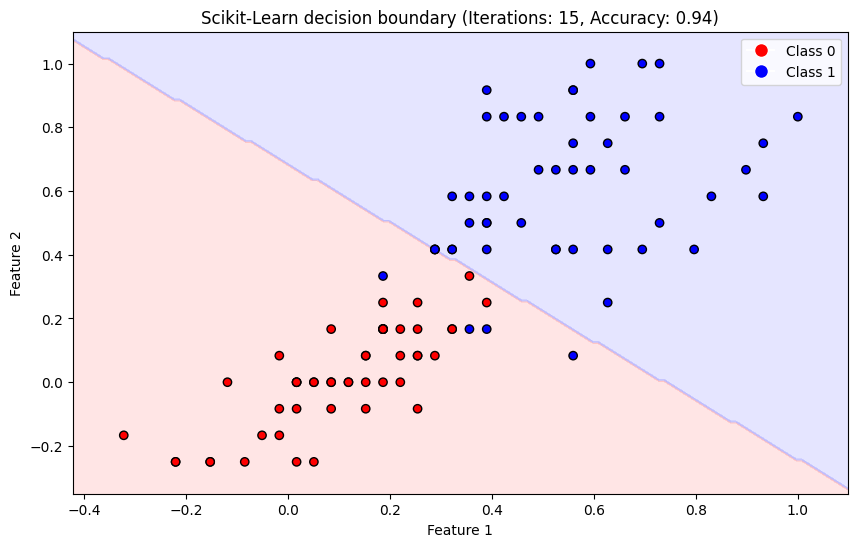

In [2]:
# Train an SGDClassifier on the binary dataset
N_ITERATIONS = 15
RANDOM_STATE = 42

sgd_clf_binary = SklearnSGDClassifier(random_state=RANDOM_STATE, max_iter=N_ITERATIONS)
sgd_clf_binary.fit(X_binary, y_binary)
y_pred = sgd_clf_binary.predict(X_binary)
accuracy = (y_pred == y_binary).mean()
plot_decision_boundary(
    sgd_clf_binary,
    X_binary,
    y_binary,
    n_iterations=N_ITERATIONS,
    accuracy=accuracy,
    title="Scikit-Learn decision boundary",
)

## Concrete ML Clear Training
Training of the a typical Concrete ML model. This handles quantization so that FHE compilation is possible.

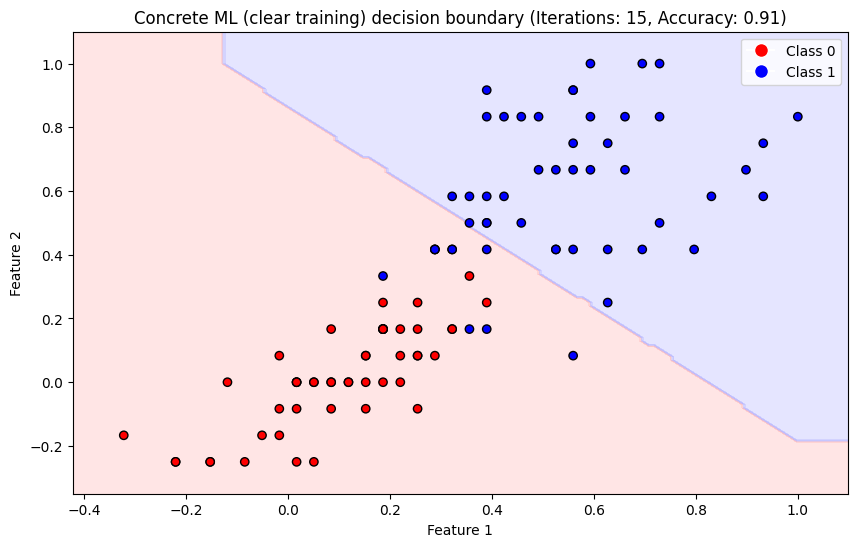

In [3]:
sgd_clf_binary_clear = SGDClassifier(
    random_state=RANDOM_STATE,
    max_iter=N_ITERATIONS,
    fit_encrypted=False,
)
sgd_clf_binary_clear.fit(X_binary, y_binary)
y_pred = sgd_clf_binary_clear.predict(X_binary)
sgd_clf_binary_clear.compile(X_binary)
y_pred_fhe = sgd_clf_binary_clear.predict(X_binary, fhe="execute")
assert np.all(y_pred == y_pred_fhe)
accuracy = (y_pred == y_binary).mean()
plot_decision_boundary(
    sgd_clf_binary_clear,
    X_binary,
    y_binary,
    n_iterations=N_ITERATIONS,
    accuracy=accuracy,
    title="Concrete ML (clear training) decision boundary",
)

## Validate Encrypted Training using Simulation

Training over encrypted data using FHE simulation.

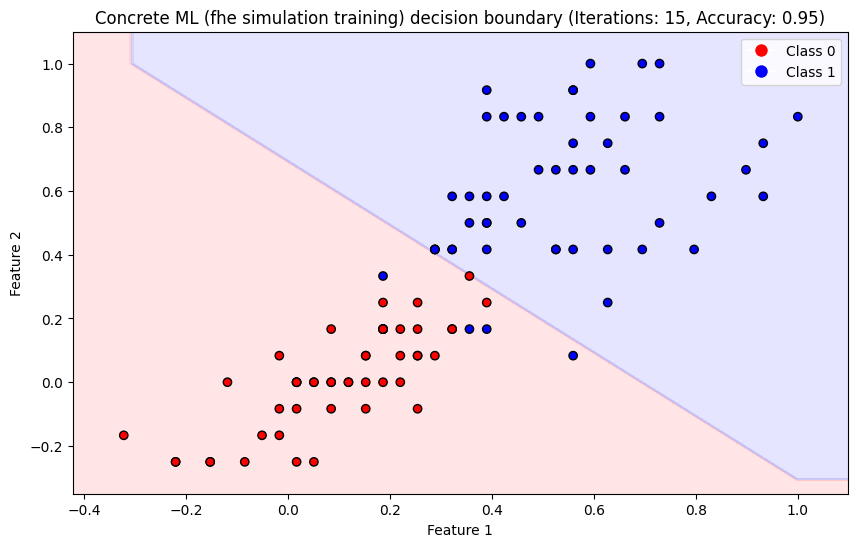

In [4]:
parameters_range = (-1.0, 1.0)

sgd_clf_binary_simulate = SGDClassifier(
    random_state=RANDOM_STATE,
    max_iter=N_ITERATIONS,
    fit_encrypted=True,
    parameters_range=parameters_range,
)

sgd_clf_binary_simulate.fit(X_binary, y_binary, fhe="simulate")

y_pred = sgd_clf_binary_simulate.predict(X_binary)

sgd_clf_binary_simulate.compile(X_binary)
y_pred_fhe = sgd_clf_binary_simulate.predict(X_binary, fhe="execute")

assert np.all(y_pred == y_pred_fhe)

accuracy = (y_pred == y_binary).mean()

plot_decision_boundary(
    sgd_clf_binary_simulate,
    X_binary,
    y_binary,
    n_iterations=N_ITERATIONS,
    accuracy=accuracy,
    title="Concrete ML (fhe simulation training) decision boundary",
)

## Encrypted Training

Training over encrypted data in FHE.

Compiling training circuit ...


Compilation took 2.8881 seconds.
Key Generation...
Key generation took 3.9791 seconds.
Training starts
Starting iteration ...


Iteration 0 took 4.1036 seconds.
Starting iteration ...


Iteration 1 took 4.0904 seconds.
Starting iteration ...


Iteration 2 took 2.8600 seconds.
Starting iteration ...


Iteration 3 took 2.6575 seconds.
Starting iteration ...


Iteration 4 took 2.6292 seconds.
Starting iteration ...


Iteration 5 took 3.9281 seconds.
Starting iteration ...


Iteration 6 took 3.0089 seconds.
Starting iteration ...


Iteration 7 took 3.3130 seconds.
Starting iteration ...


Iteration 8 took 3.2465 seconds.
Starting iteration ...


Iteration 9 took 2.7535 seconds.
Starting iteration ...


Iteration 10 took 2.5906 seconds.
Starting iteration ...


Iteration 11 took 3.3178 seconds.
Starting iteration ...


Iteration 12 took 2.7143 seconds.
Starting iteration ...


Iteration 13 took 3.2665 seconds.
Starting iteration ...


Iteration 14 took 2.8536 seconds.


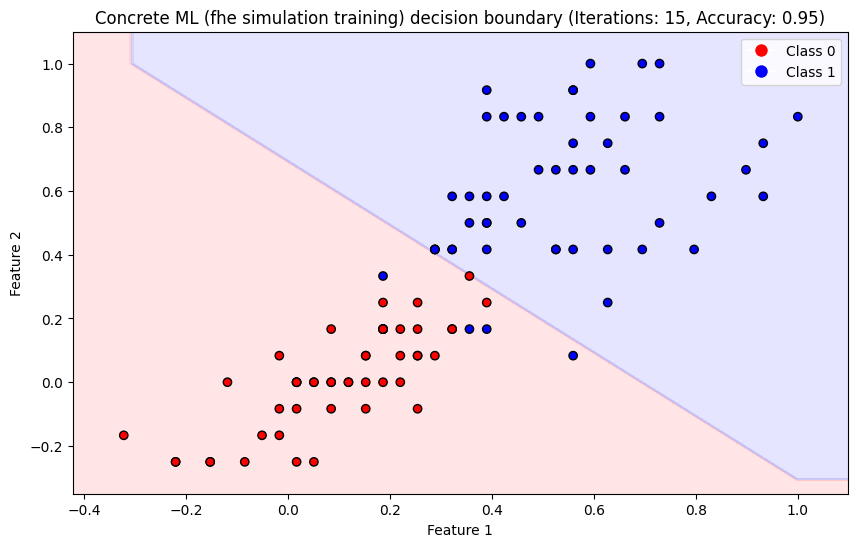

In [5]:
sgd_clf_binary_fhe = SGDClassifier(
    random_state=RANDOM_STATE,
    max_iter=N_ITERATIONS,
    fit_encrypted=True,
    parameters_range=parameters_range,
    verbose=True,
)

sgd_clf_binary_fhe.fit(X_binary, y_binary, fhe="execute")

y_pred = sgd_clf_binary_fhe.predict(X_binary)

sgd_clf_binary_fhe.compile(X_binary)
y_pred_fhe = sgd_clf_binary_fhe.predict(X_binary, fhe="execute")

assert np.all(y_pred == y_pred_fhe)

accuracy = (y_pred == y_binary).mean()

plot_decision_boundary(
    sgd_clf_binary_fhe,
    X_binary,
    y_binary,
    n_iterations=N_ITERATIONS,
    accuracy=accuracy,
    title="Concrete ML (fhe simulation training) decision boundary",
)

We can see that the final accuracy is on par with the accuracy obtained without FHE simulation.